In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from sklearn.model_selection import train_test_split

# Função para carregar e pré-processar os dados
def load_and_preprocess(filename):
    df = pd.read_csv(filename)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.drop(columns=['Air Pressure'], errors='ignore').fillna({'Interference Type': "None"})
    df = df.dropna(subset=['I/Q Data'])
    return df

# Função para normalizar os dados I/Q
def normalize_iq(iq_str):
    iq_array = np.array(eval(iq_str))
    iq_real = np.real(iq_array)
    return iq_real / np.max(np.abs(iq_real))

# Função de filtro passa-baixa
def lowpass_filter(signal_data, cutoff=0.05, order=6):
    b, a = signal.butter(order, cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, signal_data)

# Processamento dos sinais
def process_signals(df):
    df['I/Q Data'] = df['I/Q Data'].apply(normalize_iq)
    
    signal_strength_clean = -60
    signal_strength_noise = -70
    
    clean_signals = df[(df['Signal Strength'] >= signal_strength_clean) & 
                      (df['Interference Type'] == "None")].copy()
    noise_signals = df[(df['Signal Strength'] <= signal_strength_noise) | 
                    (df['Interference Type'] != "None")].copy()
    
    clean_signals['processed_signal'] = clean_signals['I/Q Data'].apply(lowpass_filter)
    noise_signals['processed_signal'] = noise_signals['I/Q Data']
    
    return clean_signals, noise_signals

# Função para criar o dataset de classificação
def create_classification_dataset(clean_signals, noise_signals, output_filename="classification_dataset.csv"):
    min_samples = min(len(clean_signals), len(noise_signals))
    clean_samples = clean_signals.sample(min_samples, random_state=42)
    noise_samples = noise_signals.sample(min_samples, random_state=42)
    
    clean_data = {
        'signal': clean_samples['processed_signal'].tolist(),
        'class': 1,  # 1 para clean
        'signal_strength': clean_samples['Signal Strength'].values,
        'interference_type': 'None'
    }
    
    noise_data = {
        'signal': noise_samples['processed_signal'].tolist(),
        'class': 0,  # 0 para noise
        'signal_strength': noise_samples['Signal Strength'].values,
        'interference_type': noise_samples['Interference Type'].values
    }
    
    df_clean = pd.DataFrame(clean_data)
    df_noise = pd.DataFrame(noise_data)
    df_final = pd.concat([df_clean, df_noise], ignore_index=True)
    
    df_final.to_csv(output_filename, index=False)
    print(f"Subdataset salvo em {output_filename} com {len(df_final)} amostras ({len(df_clean)} clean, {len(df_noise)} noise)")
    
    return df_final

# Função para criar o subdataset classification_dataset.csv1
# Função para criar o subdataset classification_dataset.csv1
def create_subdataset_from_classification(classification_df, output_filename="classification_dataset.csv1"):
    # Filtrando apenas as colunas numéricas
    classification_df_numeric = classification_df.select_dtypes(include=[np.number])

    # Garantir que o número de sinais limpos e ruidosos seja o mesmo
    num_samples = min(len(classification_df[classification_df['class'] == 1]),
                      len(classification_df[classification_df['class'] == 0]))

    clean_samples = classification_df[classification_df['class'] == 1].sample(num_samples, random_state=42)
    noise_samples = classification_df[classification_df['class'] == 0].sample(num_samples, random_state=42)

    # Criando o novo dataframe com pares de sinais
    subdataset_data = {
        'clean_signal': clean_samples['signal'].tolist(),
        'noise_signal': noise_samples['signal'].tolist(),
        'class': 1,  # Todos como 1 (poderia ser outro valor se necessário)
        'clean_signal_strength': clean_samples['signal_strength'].values,
        'noise_signal_strength': noise_samples['signal_strength'].values,
        'clean_interference_type': 'None',
        'noise_interference_type': noise_samples['interference_type'].values
    }
    
    # Criando o DataFrame
    subdataset_df = pd.DataFrame(subdataset_data)
    
    # Salvando o subdataset
    subdataset_df.to_csv(output_filename, index=False)
    print(f"Subdataset salvo em {output_filename} com {len(subdataset_df)} amostras.")
    
    return subdataset_df

# Pipeline principal
def main():
    df = load_and_preprocess("logged_data.csv")
    clean_signals, noise_signals = process_signals(df)
    classification_df = create_classification_dataset(clean_signals, noise_signals)
    
    # Criando o subdataset conforme a solicitação
    create_subdataset_from_classification(classification_df)

if __name__ == "__main__":
    main()


Subdataset salvo em classification_dataset.csv com 33402 amostras (16701 clean, 16701 noise)
Subdataset salvo em classification_dataset.csv1 com 16701 amostras.


In [2]:
df = pd.read_csv('classification_dataset.csv1')
df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.06753569 0.06815317 0.06744601 0.065591...,[-0.51403025 0.07929418 -1. 0.282124...,1,-7,-87,NaN,Co-channel
1,[ 0.19205764 0.17679055 0.16082618 0.144290...,[ 0.70620408 -0.18568454 0.06479348 -0.641807...,1,-42,-39,NaN,Intermodulation
2,[ 6.11258258e-01 5.52137776e-01 4.92440591e-...,[ 0.62373061 -0.16386374 0.79554744 0.913140...,1,-18,-66,NaN,Co-channel
3,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,[ 0.13570954 -0.06391973 0.29180463 0.637100...,1,-3,-29,NaN,Co-channel
4,[-2.83198484e-01 -2.52492646e-01 -2.22086926e-...,[ 1.67946804e-01 -2.21649870e-01 -2.38364748e-...,1,-9,-49,NaN,Co-channel
...,...,...,...,...,...,...,...
16696,[ 0.33583505 0.30042465 0.2668221 0.235250...,[-0.08967906 -0.76337204 -0.22428849 0.075496...,1,-30,-90,NaN,NaN
16697,[ 0.35694581 0.30739893 0.25751277 0.207717...,[-0.02974317 -0.94572458 0.67620933 -0.383027...,1,-40,-61,NaN,Co-channel
16698,[-9.16795722e-01 -8.38317861e-01 -7.60477905e-...,[ 0.46575862 -0.87626119 -0.96593695 0.493635...,1,-46,-81,NaN,Adjacent-channel
16699,[ 0.30016228 0.30411639 0.30551647 0.304368...,[ 0.6037686 -0.50345037 -0.08180763 0.559866...,1,-42,-28,NaN,Adjacent-channel


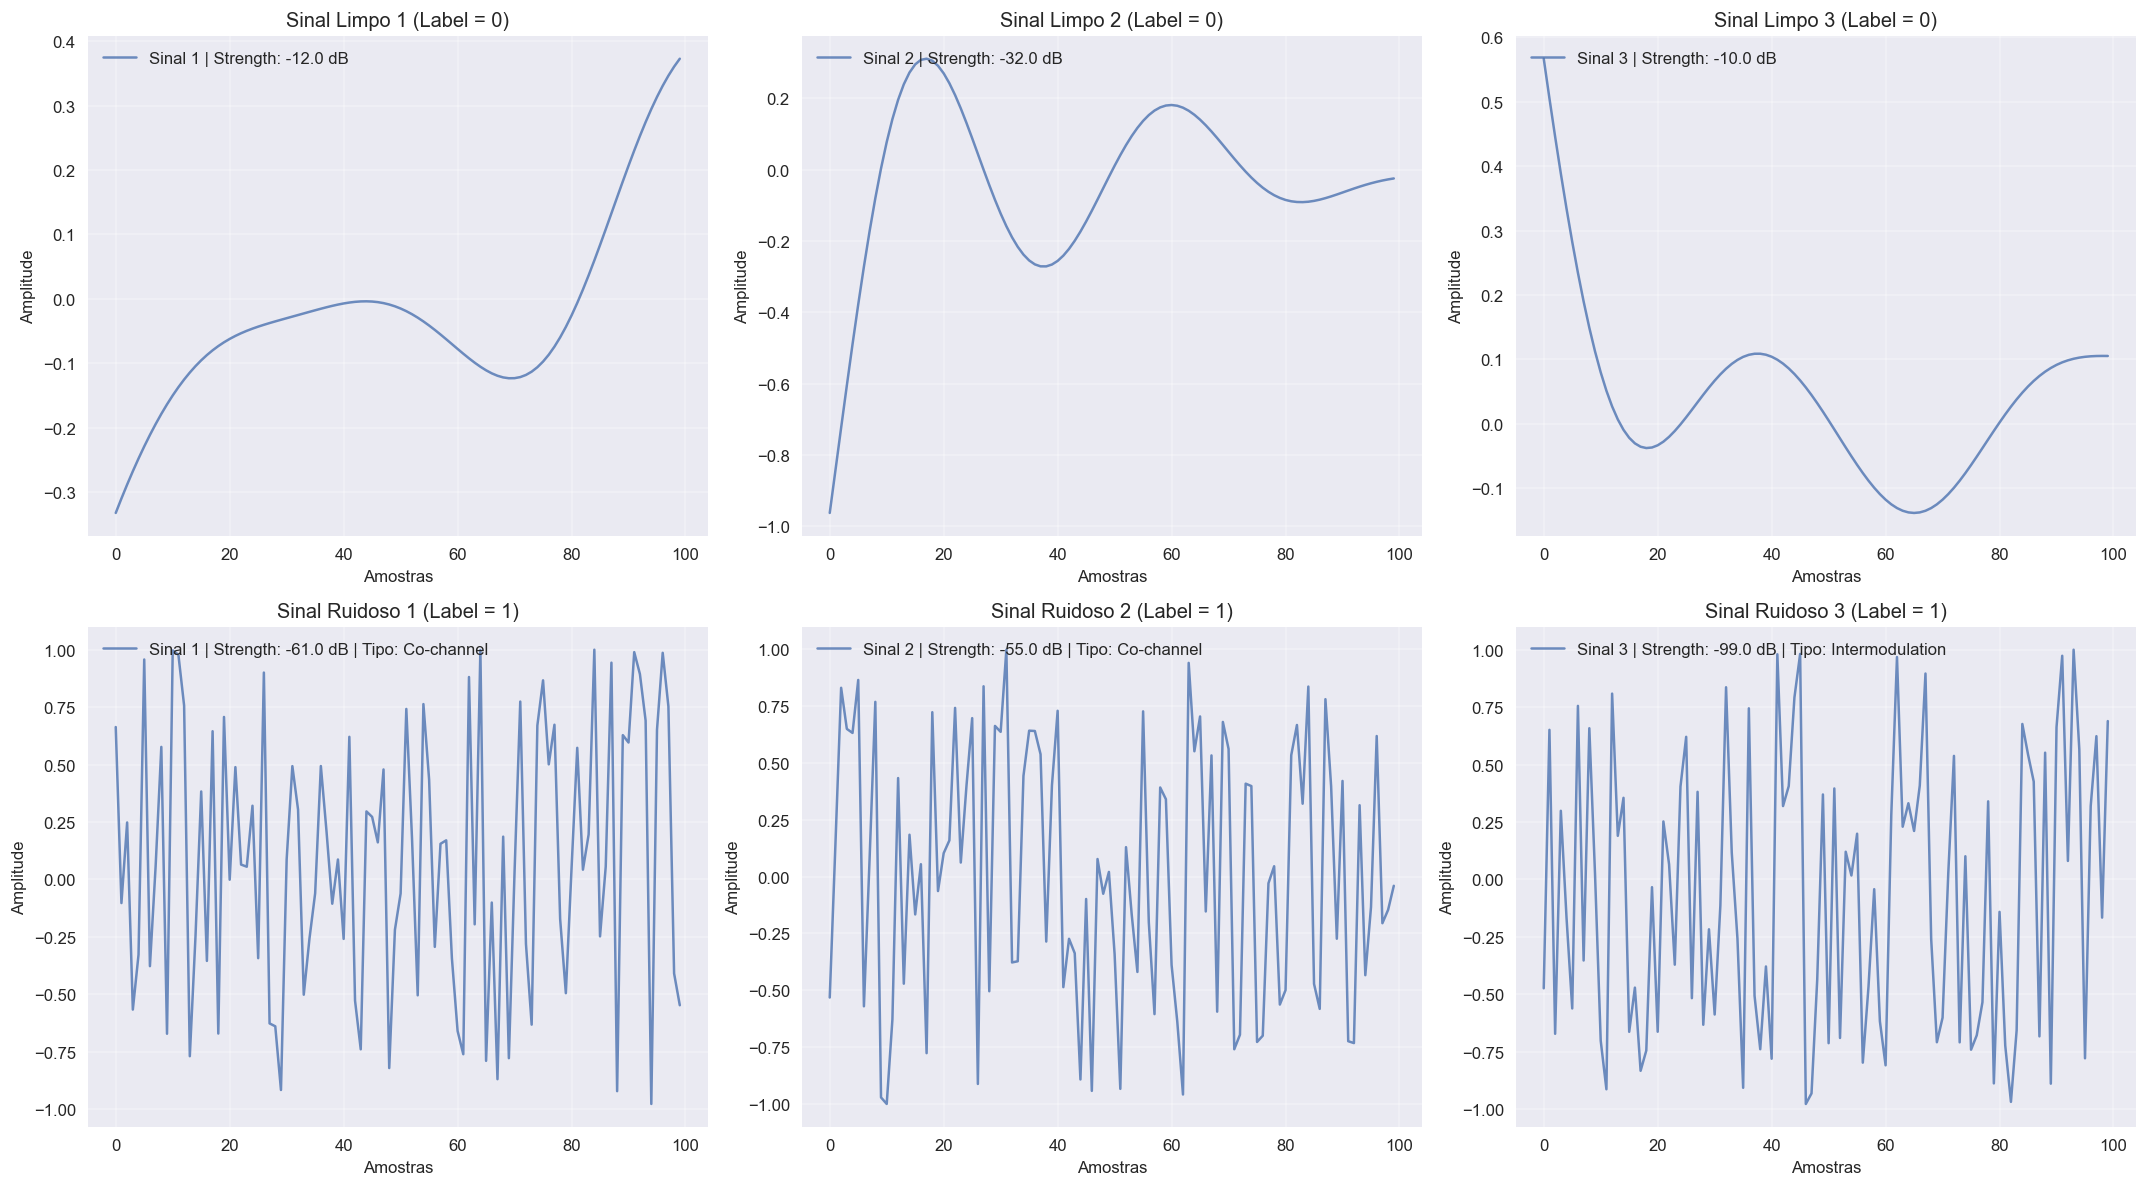

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Carregar o dataset
try:
    df = pd.read_csv("classification_dataset.csv")
except FileNotFoundError:
    raise FileNotFoundError("Arquivo 'classification_dataset.csv' não encontrado. Verifique o caminho.")

# Função para converter os sinais
def convert_signal(signal_str):
    if isinstance(signal_str, str):
        try:
            return np.array(ast.literal_eval(signal_str))
        except:
            cleaned = signal_str.strip('[]').replace('\n', ' ').split()
            return np.array([float(x) for x in cleaned])
    return signal_str

df['signal'] = df['signal'].apply(convert_signal)

# Configurações dos gráficos
try:
    plt.style.use('seaborn-v0_8')  # Estilo mais moderno
except:
    plt.style.use('ggplot')  # Fallback para outro estilo

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

# 1. Criar uma figura com subgráficos para sinais limpos e ruidosos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 linhas, 3 colunas

# Gráficos para sinais LIMPOS
clean_signals = df[df['class'] == 1]
if not clean_signals.empty:
    for i in range(min(3, len(clean_signals))):
        signal = clean_signals.iloc[i]['signal']
        strength = clean_signals.iloc[i]['signal_strength']
        
        ax = axes[0, i]  # Acessa o subgráfico correspondente na primeira linha
        ax.plot(signal[:200], label=f"Sinal {i+1} | Strength: {strength:.1f} dB", alpha=0.8, linewidth=1.5)
        ax.set_title(f'Sinal Limpo {i+1} (Label = 0)', fontsize=12)
        ax.set_xlabel('Amostras', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

# Gráficos para sinais RUIDOSOS
noisy_signals = df[df['class'] == 0]
if not noisy_signals.empty:
    for i in range(min(3, len(noisy_signals))):
        signal = noisy_signals.iloc[i]['signal']
        strength = noisy_signals.iloc[i]['signal_strength']
        interference = noisy_signals.iloc[i]['interference_type']
        
        ax = axes[1, i]  # Acessa o subgráfico correspondente na segunda linha
        ax.plot(signal[:200], label=f"Sinal {i+1} | Strength: {strength:.1f} dB | Tipo: {interference}", alpha=0.8, linewidth=1.5)
        ax.set_title(f'Sinal Ruidoso {i+1} (Label = 1)', fontsize=12)
        ax.set_xlabel('Amostras', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.savefig('sinais_comparados.png', bbox_inches='tight')  # Salva a figura
plt.show()


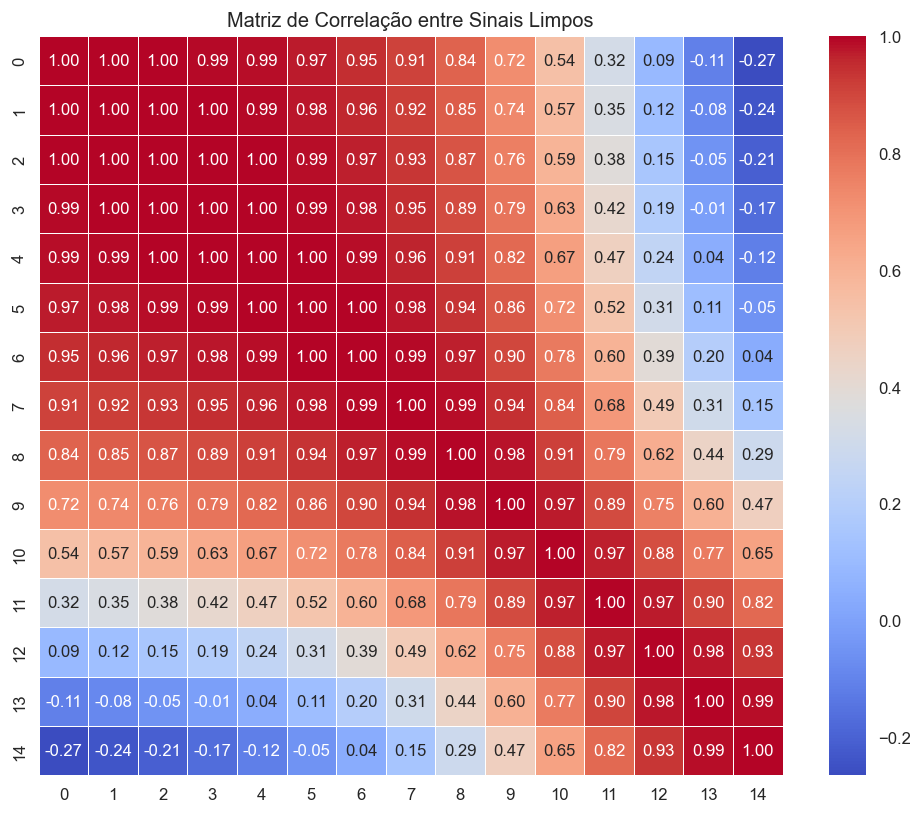

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Função para corrigir a string e transformá-la em uma lista válida
def clean_signal_to_array(signal_str):
    # Remover espaços extras ou outros caracteres indesejados e tentar converter
    signal_str = signal_str.strip()  # Remover espaços extras
    signal_str = signal_str.replace('[', '').replace(']', '')  # Garantir que a lista esteja correta
    signal_list = np.array([float(x) for x in signal_str.split()])  # Converter a string em uma lista de floats
    return signal_list

# Carregar o dataset de classificação
classification_df = pd.read_csv("classification_dataset.csv1")

# Converter os sinais limpos de strings para arrays numéricos
clean_signals = np.array([clean_signal_to_array(signal) for signal in classification_df['clean_signal']])

# Limitar a matriz para as primeiras 20 variáveis
clean_signals_subset = clean_signals[:, :15]

# Calcular a matriz de correlação para apenas os 20 primeiros sinais
correlation_matrix = np.corrcoef(clean_signals_subset, rowvar=False)

# Plotar o gráfico da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Sinais Limpos')
plt.show()


In [5]:
import pandas as pd
import numpy as np

# Função para corrigir a string e transformá-la em uma lista válida (mesma do primeiro bloco)
def clean_signal_to_array(signal_str):
    signal_str = signal_str.strip()
    signal_str = signal_str.replace('[', '').replace(']', '')
    signal_list = np.array([float(x) for x in signal_str.split()])
    return signal_list

# Carregar o dataset de classificação
classification_df = pd.read_csv("classification_dataset.csv1")

# Converter os sinais limpos de strings para arrays numéricos (como no primeiro bloco)
clean_signals = np.array([clean_signal_to_array(signal) for signal in classification_df['clean_signal']])

# Calcular a matriz de correlação para todos os sinais
correlation_matrix = np.corrcoef(clean_signals, rowvar=False)

# Função para criar novo dataset (adaptada para trabalhar com arrays numpy)
def create_new_dataset(correlation_matrix, signals_array, min_correlation=0.5):
    new_clean_signals = []
    new_noisy_signals = []
    
    num_signals = signals_array.shape[1]
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(i + 1, correlation_matrix.shape[1]):
            if i < num_signals and j < num_signals:
                if abs(correlation_matrix[i, j]) < min_correlation:
                    # Adiciona todos os pontos dos sinais i e j como pares
                    new_clean_signals.extend(signals_array[:, i].tolist())
                    new_noisy_signals.extend(signals_array[:, j].tolist())
    
    # Criar DataFrame - agora cada linha contém um valor único (não todo o sinal)
    new_dataset_Zero = pd.DataFrame({
        'clean_signal': new_clean_signals,
        'noisy_signal': new_noisy_signals,
        'Class': [0] * len(new_clean_signals)
    })
    
    return new_dataset_Zero

# Criar o novo dataset
new_dataset_Zero = create_new_dataset(correlation_matrix, clean_signals, min_correlation=0.5)

# Salvar o novo dataset
new_dataset_Zero.to_csv("classification_dataset.csv0", index=False)

In [6]:
import pandas as pd
import numpy as np

# Função para processar os sinais (igual ao anterior)
def clean_signal_to_array(signal_str):
    signal_str = signal_str.strip().replace('[', '').replace(']', '')
    return np.array([float(x) for x in signal_str.split()])

# Carregar o dataset
classification_df = pd.read_csv("classification_dataset.csv1")

# Converter para array numpy (limitar a N sinais para teste)
N = 5  # Ajuste conforme necessário
clean_signals = np.array([clean_signal_to_array(s) for s in classification_df['clean_signal'].head(N)])

# Transpor para ter variáveis nas colunas (rowvar=False)
clean_signals = clean_signals.T  # Formato (n_features, n_samples)

# Calcular correlação (rápido se N não for muito grande)
correlation_matrix = np.corrcoef(clean_signals)

# Obter índices dos pares com correlação < limiar
min_corr = 0.5
i, j = np.where(np.triu(np.abs(correlation_matrix) < min_corr, k=1))

# Pré-alocar arrays para os novos dados
n_pares = len(i)
new_clean = np.zeros(n_pares * clean_signals.shape[1])
new_noisy = np.zeros_like(new_clean)

# Preencher os arrays de forma vetorizada (rápido)
for idx, (a, b) in enumerate(zip(i, j)):
    start = idx * clean_signals.shape[1]
    end = start + clean_signals.shape[1]
    new_clean[start:end] = clean_signals[a]
    new_noisy[start:end] = clean_signals[b]

# Criar DataFrame final
new_dataset = pd.DataFrame({
    'clean_signal': new_clean,
    'noisy_signal': new_noisy,
    'Class': 0  # Todos são classe 0
})

# Salvar
new_dataset.to_csv("classification_dataset.csv0", index=False)
print("Dataset salvo com sucesso!")

Dataset salvo com sucesso!


In [7]:
df = pd.read_csv('classification_dataset.csv0')
df

,clean_signal,noisy_signal,Class
0,0.067536,0.027501,0
1,0.192058,0.009606,0
2,0.611258,0.038119,0
3,0.549523,-0.035545,0
4,-0.283198,-0.022526,0
...,...,...,...
12585,0.117830,0.188914,0
12586,0.018352,0.064196,0
12587,0.064138,0.161126,0
12588,-0.001136,0.051612,0


In [8]:
import pandas as pd
import numpy as np

# Função para converter array em string no formato "[v1 v2 v3 ...]"
def array_to_str(arr):
    return "[" + " ".join(map(str, arr)) + "]"

# Função para processar os sinais (igual ao CSV original)
def clean_signal_to_array(signal_str):
    signal_str = signal_str.strip().replace('[', '').replace(']', '')
    return np.array([float(x) for x in signal_str.split()])

# Carregar o dataset original
df = pd.read_csv("classification_dataset.csv1")

# Limitar a N amostras para evitar demora (ajuste conforme necessário)
N = 100 if len(df) > 100 else len(df)
df = df.head(N).copy()

# Converter 'clean_signal' para arrays numpy
clean_arrays = np.array([clean_signal_to_array(s) for s in df['clean_signal']])

# Calcular matriz de correlação (entre sinais, não entre pontos)
correlation_matrix = np.corrcoef(clean_arrays)

# Encontrar pares com correlação < limiar (0.5)
min_corr = 0.5
low_corr_pairs = []
n = len(clean_arrays)

for i in range(n):
    for j in range(i + 1, n):
        if abs(correlation_matrix[i, j]) < min_corr:
            low_corr_pairs.append((i, j))

# Criar um novo DataFrame com a mesma estrutura do original
new_data = []

for i, j in low_corr_pairs:
    # Copiar as linhas i e j, trocando clean e noise
    row_i = df.iloc[i].copy()
    row_j = df.iloc[j].copy()
    
    # Criar novas entradas com clean_signal de i e noise_signal de j (e vice-versa)
    new_row_1 = {
        'clean_signal': row_i['clean_signal'],
        'noise_signal': row_j['clean_signal'],  # Usamos clean_signal do outro como ruído
        'class': 0,  # Nova classe para pares artificiais
        'clean_signal_strength': row_i['clean_signal_strength'],
        'noise_signal_strength': row_j['clean_signal_strength'],
        'clean_interference_type': row_i['clean_interference_type'],
        'noise_interference_type': row_j['clean_interference_type']
    }
    
    new_row_2 = {
        'clean_signal': row_j['clean_signal'],
        'noise_signal': row_i['clean_signal'],  # Inverso
        'class': 0,
        'clean_signal_strength': row_j['clean_signal_strength'],
        'noise_signal_strength': row_i['clean_signal_strength'],
        'clean_interference_type': row_j['clean_interference_type'],
        'noise_interference_type': row_i['clean_interference_type']
    }
    
    new_data.extend([new_row_1, new_row_2])

# Converter para DataFrame e salvar
new_df = pd.DataFrame(new_data)
new_df.to_csv("classification_dataset.csv0", index=False)

print(f"Novo dataset salvo com {len(new_df)} linhas.")

Novo dataset salvo com 5758 linhas.


In [9]:
df = pd.read_csv('classification_dataset.csv0')
df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 0.19205764 0.17679055 0.16082618 0.144290...,0,-7,-42,NaN,NaN
1,[ 0.19205764 0.17679055 0.16082618 0.144290...,[ 0.06753569 0.06815317 0.06744601 0.065591...,0,-42,-7,NaN,NaN
2,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,0,-7,-3,NaN,NaN
3,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,[ 0.06753569 0.06815317 0.06744601 0.065591...,0,-3,-7,NaN,NaN
4,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 0.67484609 0.62580103 0.57559216 0.524850...,0,-7,-59,NaN,NaN
...,...,...,...,...,...,...,...
5753,[ 0.51840768 0.46660436 0.41429272 0.362104...,[-0.18876917 -0.16930172 -0.14967476 -0.130336...,0,-7,-51,NaN,NaN
5754,[-0.18876917 -0.16930172 -0.14967476 -0.130336...,[ 1.0019709 0.88046737 0.76008985 0.642387...,0,-51,-24,NaN,NaN
5755,[ 1.0019709 0.88046737 0.76008985 0.642387...,[-0.18876917 -0.16930172 -0.14967476 -0.130336...,0,-24,-51,NaN,NaN
5756,[ 0.95897465 0.87458661 0.7914237 0.710050...,[ 0.51840768 0.46660436 0.41429272 0.362104...,0,-10,-7,NaN,NaN


In [10]:
import pandas as pd
import numpy as np

# Carregar os datasets
df1 = pd.read_csv("classification_dataset.csv1")  # Dataset original
df0 = pd.read_csv("classification_dataset.csv0")  # Dataset gerado com pares de baixa correlação

# Determinar o tamanho do menor dataset
min_size = min(len(df1), len(df0))

# Balancear os datasets (selecionar 'min_size' amostras de cada)
df1_balanced = df1.sample(n=min_size, random_state=42)  # Amostra aleatória
df0_balanced = df0.sample(n=min_size, random_state=42)  # Amostra aleatória

# Concatenar os datasets balanceados
final_df = pd.concat([df1_balanced, df0_balanced], ignore_index=True)

# Embaralhar as linhas do DataFrame final
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Salvar o dataset final
final_df.to_csv("final_classification_dataset.csv", index=False)

print(f"Dataset final salvo com {len(final_df)} linhas.")
print(f"Distribuição das classes:")
print(final_df['class'].value_counts())

Dataset final salvo com 11516 linhas.
Distribuição das classes:
class
1    5758
0    5758
Name: count, dtype: int64


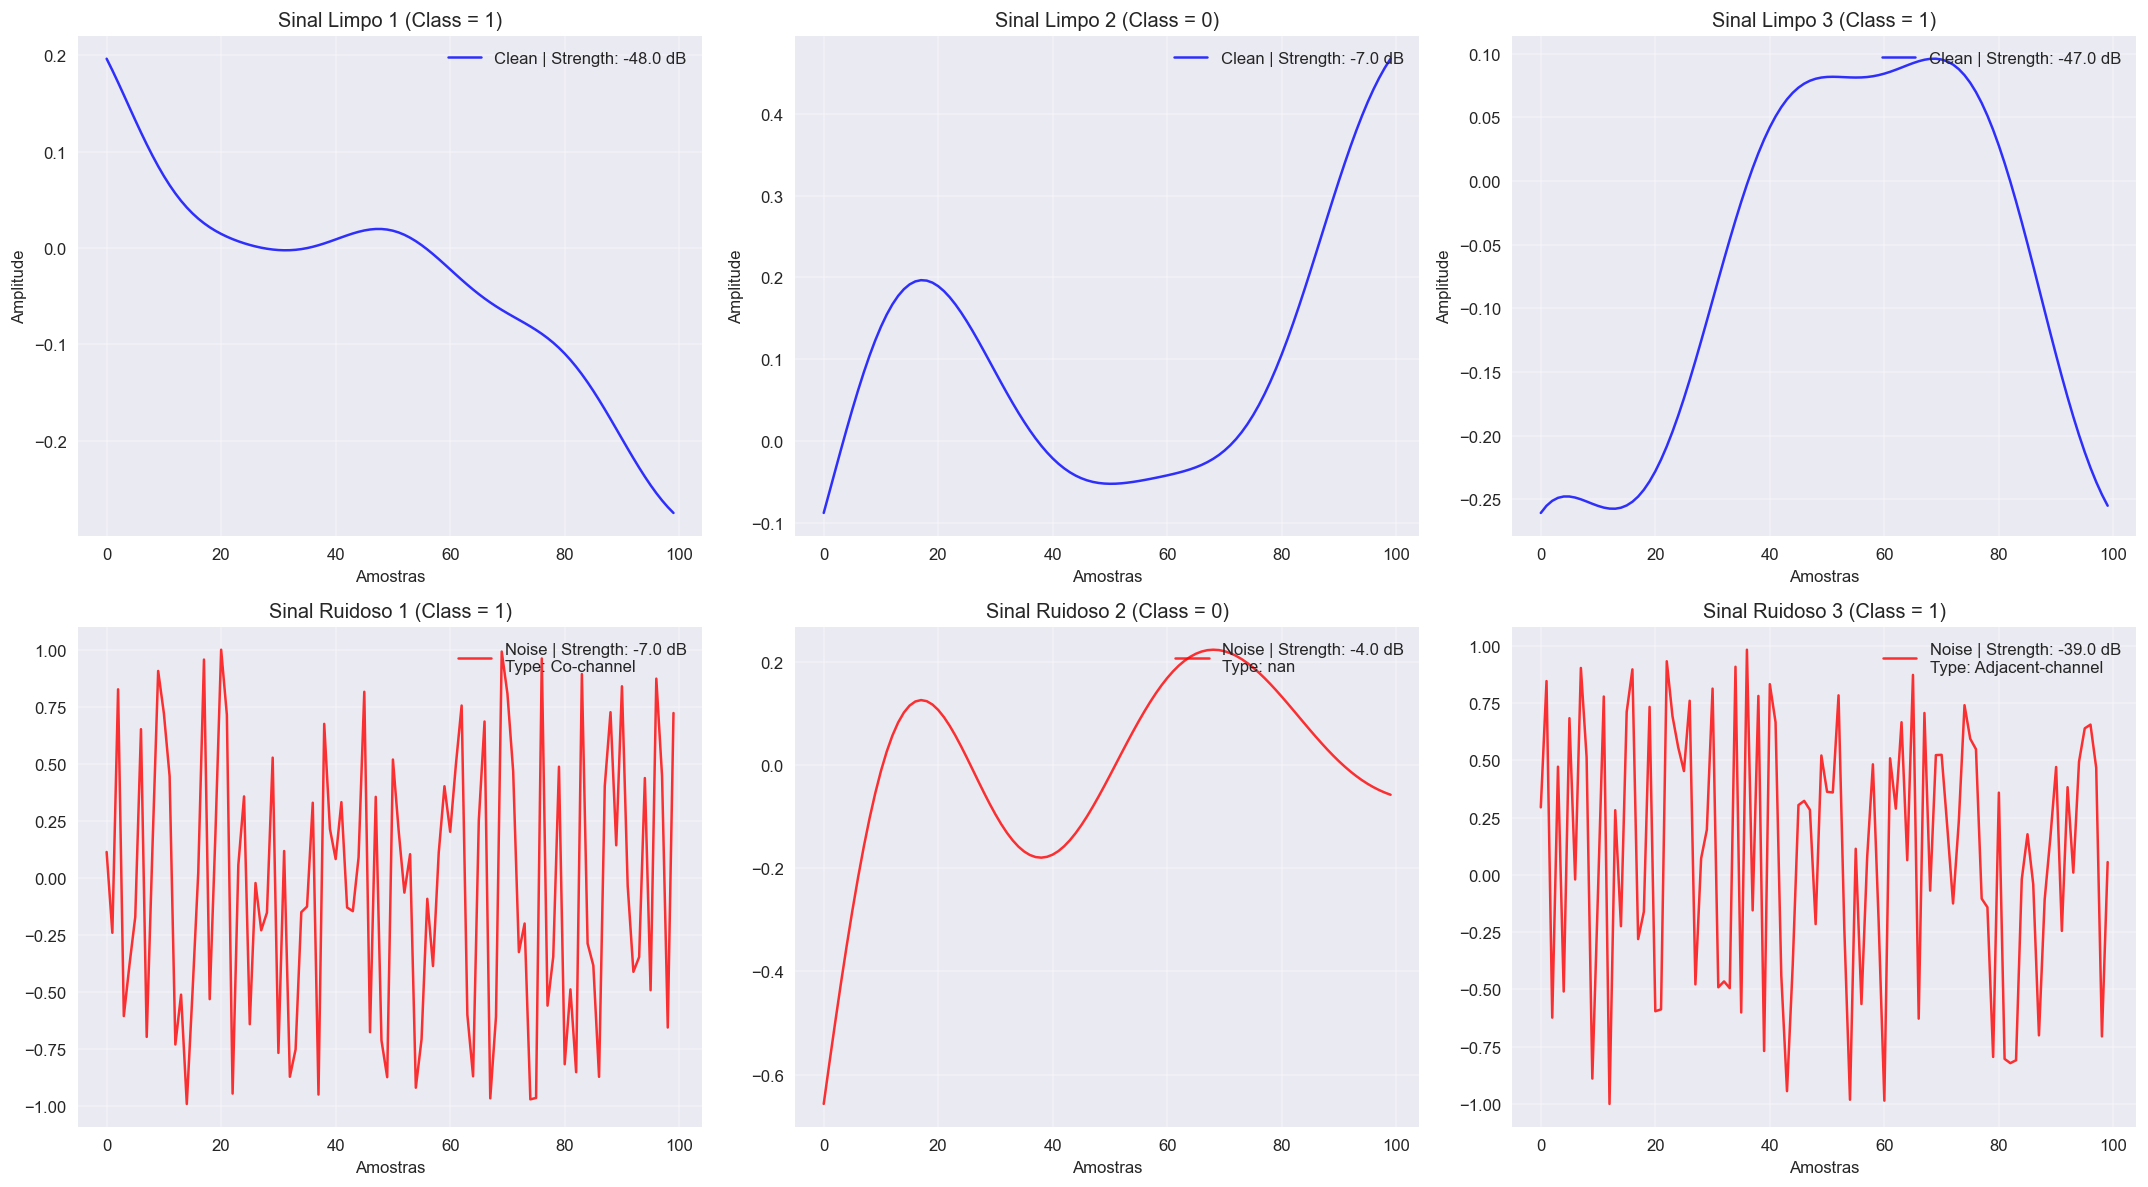

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Carregar o dataset final
try:
    df = pd.read_csv("final_classification_dataset.csv")
except FileNotFoundError:
    raise FileNotFoundError("Arquivo 'final_classification_dataset.csv' não encontrado. Verifique o caminho.")

# Função para converter os sinais (adaptada para o formato do dataset final)
def convert_signal(signal_str):
    if isinstance(signal_str, str):
        try:
            # Remove colchetes e converte para array numpy
            cleaned = signal_str.strip('[]').replace('\n', ' ').split()
            return np.array([float(x) for x in cleaned])
        except:
            return np.array([])
    return signal_str

# Aplicar conversão para as colunas de sinal
df['clean_signal'] = df['clean_signal'].apply(convert_signal)
df['noise_signal'] = df['noise_signal'].apply(convert_signal)

# Configurações dos gráficos
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

# 1. Criar figura com subgráficos para comparar clean vs noise
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 linhas, 3 colunas

# Selecionar exemplos aleatórios
np.random.seed(42)
sample_indices = np.random.choice(len(df), size=3, replace=False)

# Gráficos para sinais LIMPOS (class = 1)
for i, idx in enumerate(sample_indices):
    row = df.iloc[idx]
    clean_signal = row['clean_signal']
    noise_signal = row['noise_signal']
    class_label = row['class']
    
    # Plot sinal limpo (primeira linha)
    ax = axes[0, i]
    ax.plot(clean_signal[:200], 
            label=f"Clean | Strength: {row['clean_signal_strength']:.1f} dB",
            color='blue', alpha=0.8, linewidth=1.5)
    ax.set_title(f'Sinal Limpo {i+1} (Class = {class_label})', fontsize=12)
    ax.set_xlabel('Amostras', fontsize=10)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

    # Plot sinal ruidoso (segunda linha)
    ax = axes[1, i]
    ax.plot(noise_signal[:200], 
            label=f"Noise | Strength: {row['noise_signal_strength']:.1f} dB\nType: {row['noise_interference_type']}",
            color='red', alpha=0.8, linewidth=1.5)
    ax.set_title(f'Sinal Ruidoso {i+1} (Class = {class_label})', fontsize=12)
    ax.set_xlabel('Amostras', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('sinais_finais_comparados.png', bbox_inches='tight', dpi=150)
plt.show()